# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


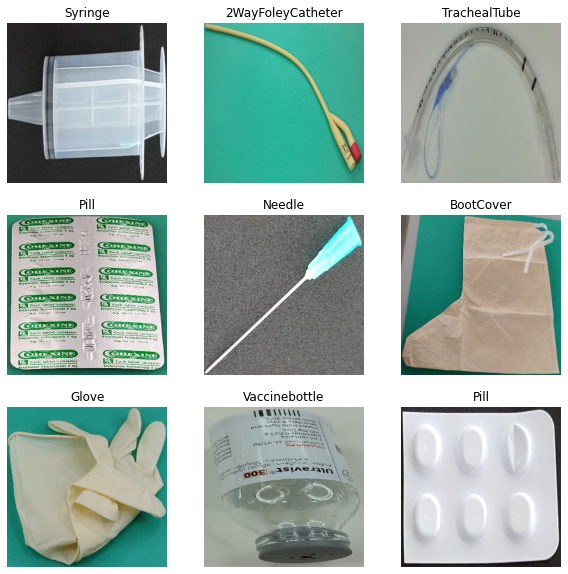

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
EPOCHS = 2000
save_model_interval = 10
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 69s 756ms/step - loss: 1.1044 - accuracy: 0.7099 - val_loss: 3.7707 - val_accuracy: 0.0246
Epoch 2/2000
49/49 [==============================] - 27s 557ms/step - loss: 0.3300 - accuracy: 0.8969 - val_loss: 4.9180 - val_accuracy: 0.1048
Epoch 3/2000
49/49 [==============================] - 27s 558ms/step - loss: 0.1675 - accuracy: 0.9538 - val_loss: 1.4919 - val_accuracy: 0.6481
Epoch 4/2000
49/49 [==============================] - 27s 558ms/step - loss: 0.0955 - accuracy: 0.9722 - val_loss: 1.9112 - val_accuracy: 0.6326
Epoch 5/2000
49/49 [==============================] - 27s 558ms/step - loss: 0.1135 - accuracy: 0.9654 - val_loss: 1.1828 - val_accuracy: 0.7671
Epoch 6/2000
49/49 [==============================] - 27s 559ms/step - loss: 0.1591 - accuracy: 0.9544 - val_loss: 2.7478 - val_accuracy: 0.6028
Epoch 7/2000
49/49 [==============================] - 27s 559ms/step - loss: 0.1164 - accuracy: 0.9658 - val_loss: 1.0512 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

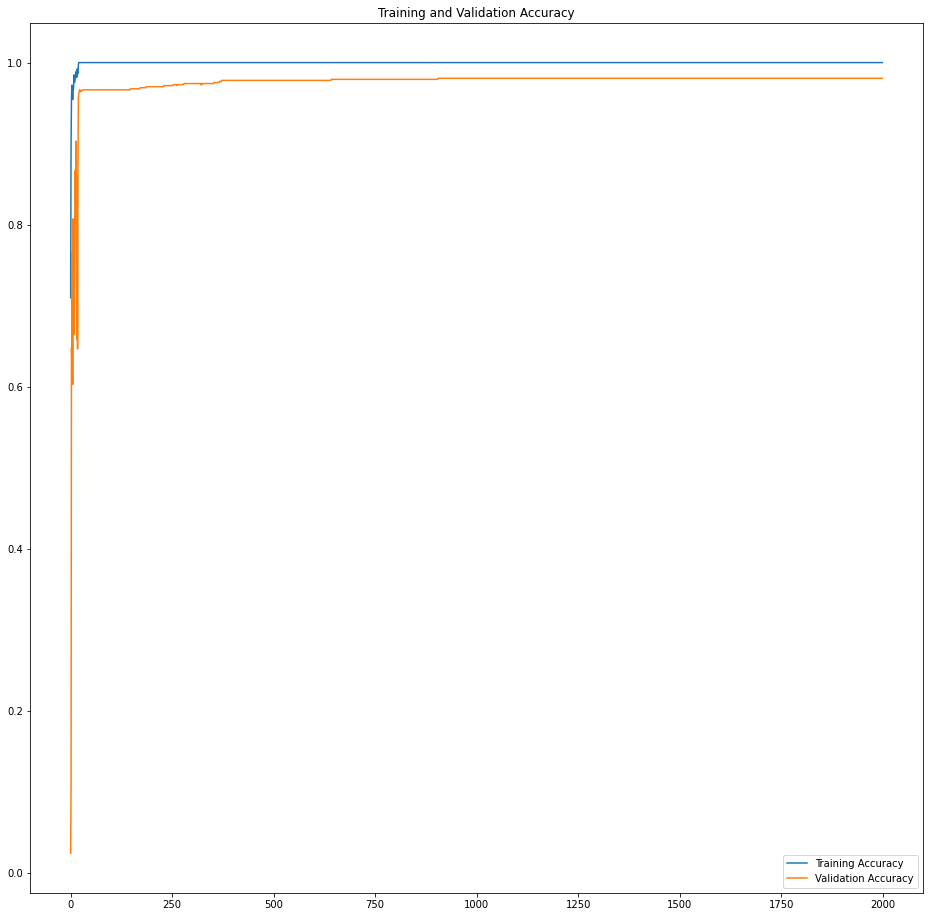

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


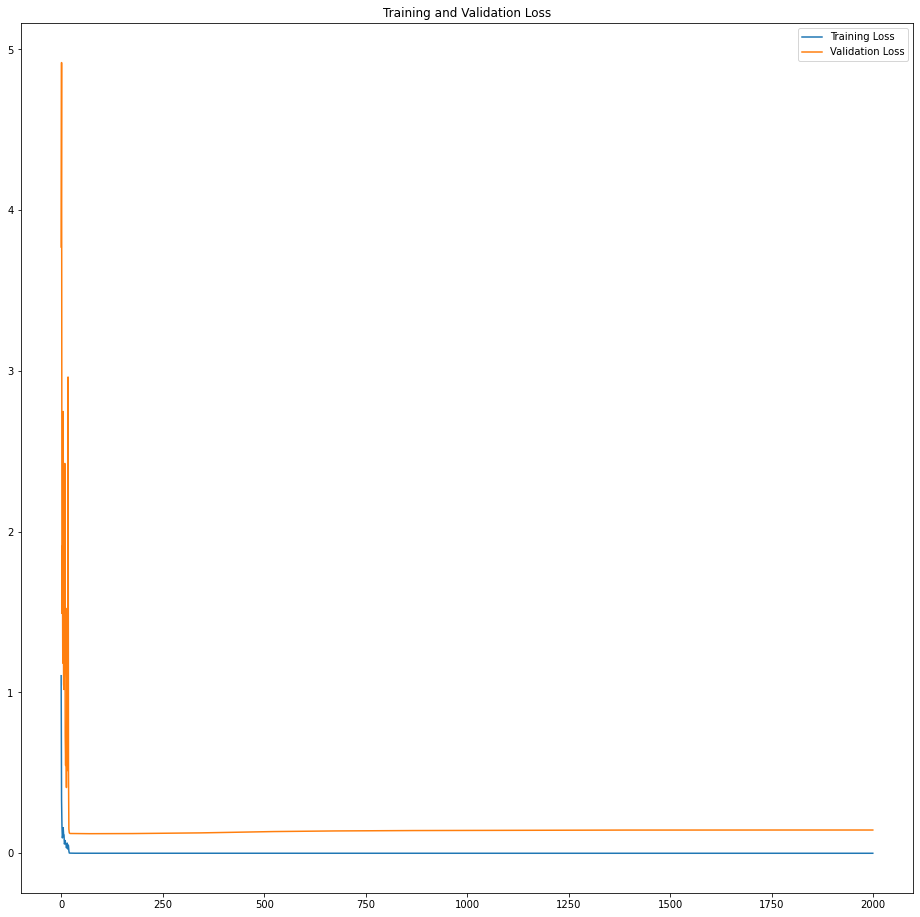

In [22]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 353ms/step - loss: 2.4748 - accuracy: 0.6355
test_indoor_ds_results:test loss, test acc: [2.4747722148895264, 0.6354514956474304]


In [24]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 454ms/step - loss: 2.1913 - accuracy: 0.6697
test_outdoor_ds_results:test loss, test acc: [2.1913249492645264, 0.6697452068328857]


In [25]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 203ms/step - loss: 1.3976 - accuracy: 0.7616
test_belt_ds_results:test loss, test acc: [1.3975881338119507, 0.7615593671798706]


In [26]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0010-val_acc0.66.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0020-val_acc0.96.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0030-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0050-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0060-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassI

In [27]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 135ms/step - loss: 5.3378 - accuracy: 0.3681
Epoch010 
 test_indoor_acc=0.1588628739118576 
 test_outdoor_acc=0.3165605068206787 
 test_belt_acc=0.3680870234966278
35/35 [==============================] - 5s 134ms/step - loss: 1.7305 - accuracy: 0.6636
Epoch020 
 test_indoor_acc=0.47491639852523804 
 test_outdoor_acc=0.6092356443405151 
 test_belt_acc=0.6636446118354797
35/35 [==============================] - 5s 135ms/step - loss: 1.4588 - accuracy: 0.6990
Epoch030 
 test_indoor_acc=0.5551839470863342 
 test_outdoor_acc=0.6449044346809387 
 test_belt_acc=0.699002742767334
35/35 [==============================] - 5s 136ms/step - loss: 1.4375 - accuracy: 0.7058
Epoch040 
 test_indoor_acc=0.5579710006713867 
 test_outdoor_acc=0.6471337676048279 
 test_belt_acc=0.7058023810386658
35/35 [==============================] - 5s 136ms/step - loss: 1.4337 - accuracy: 0.7081
Epoch050 
 test_indoor_acc=0.5590858459472656 
 test_outdoor_acc=0.648726105690

range(10, 2010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

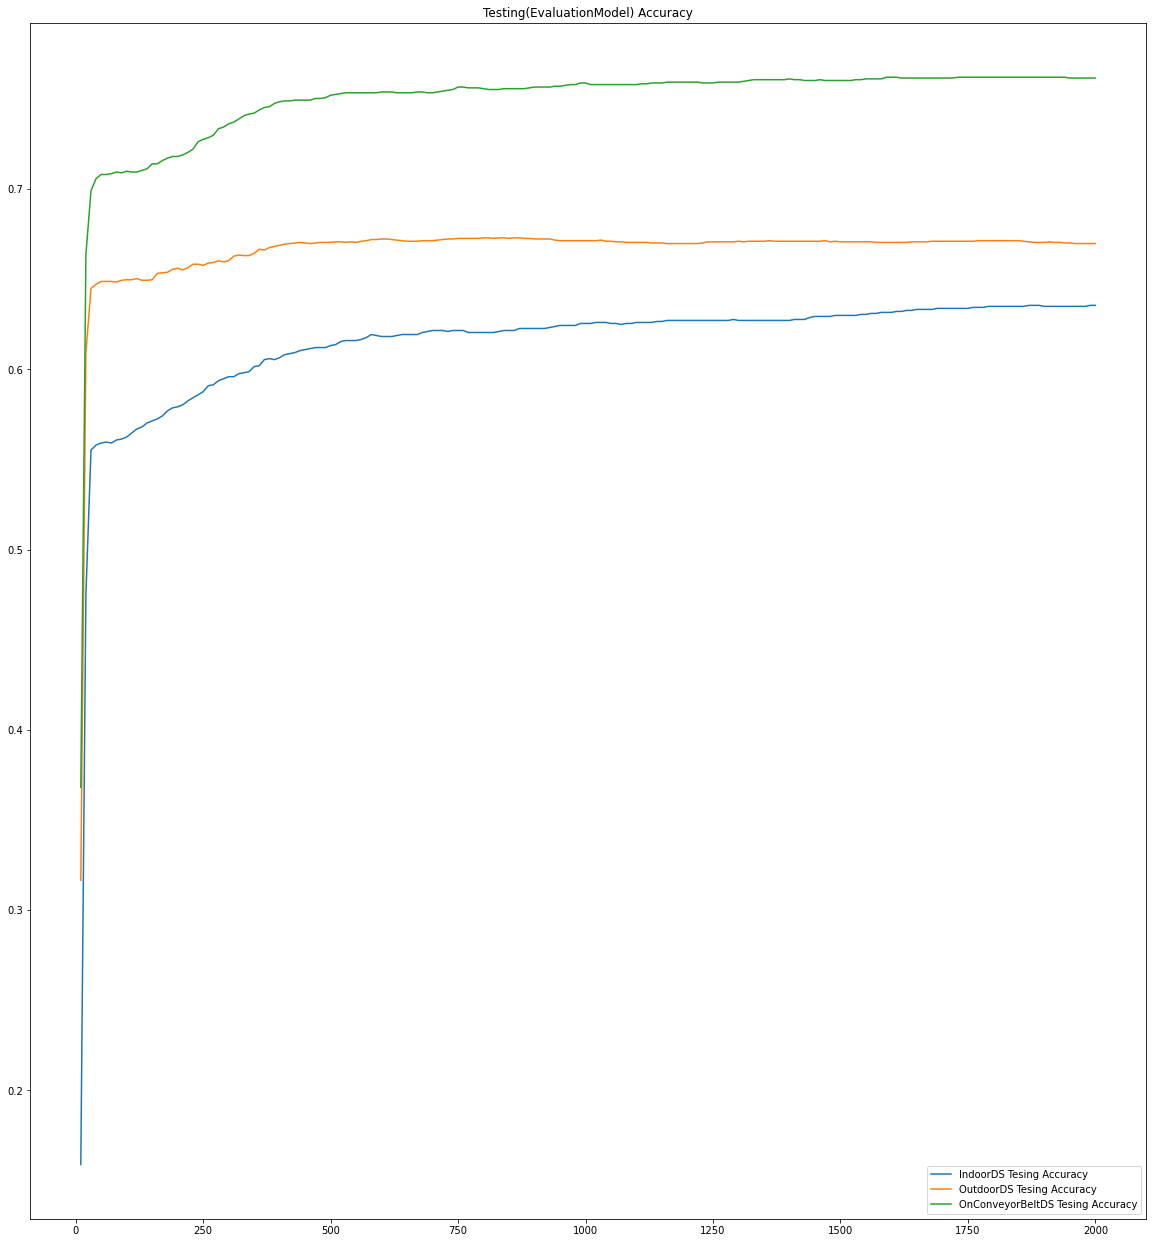

In [28]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

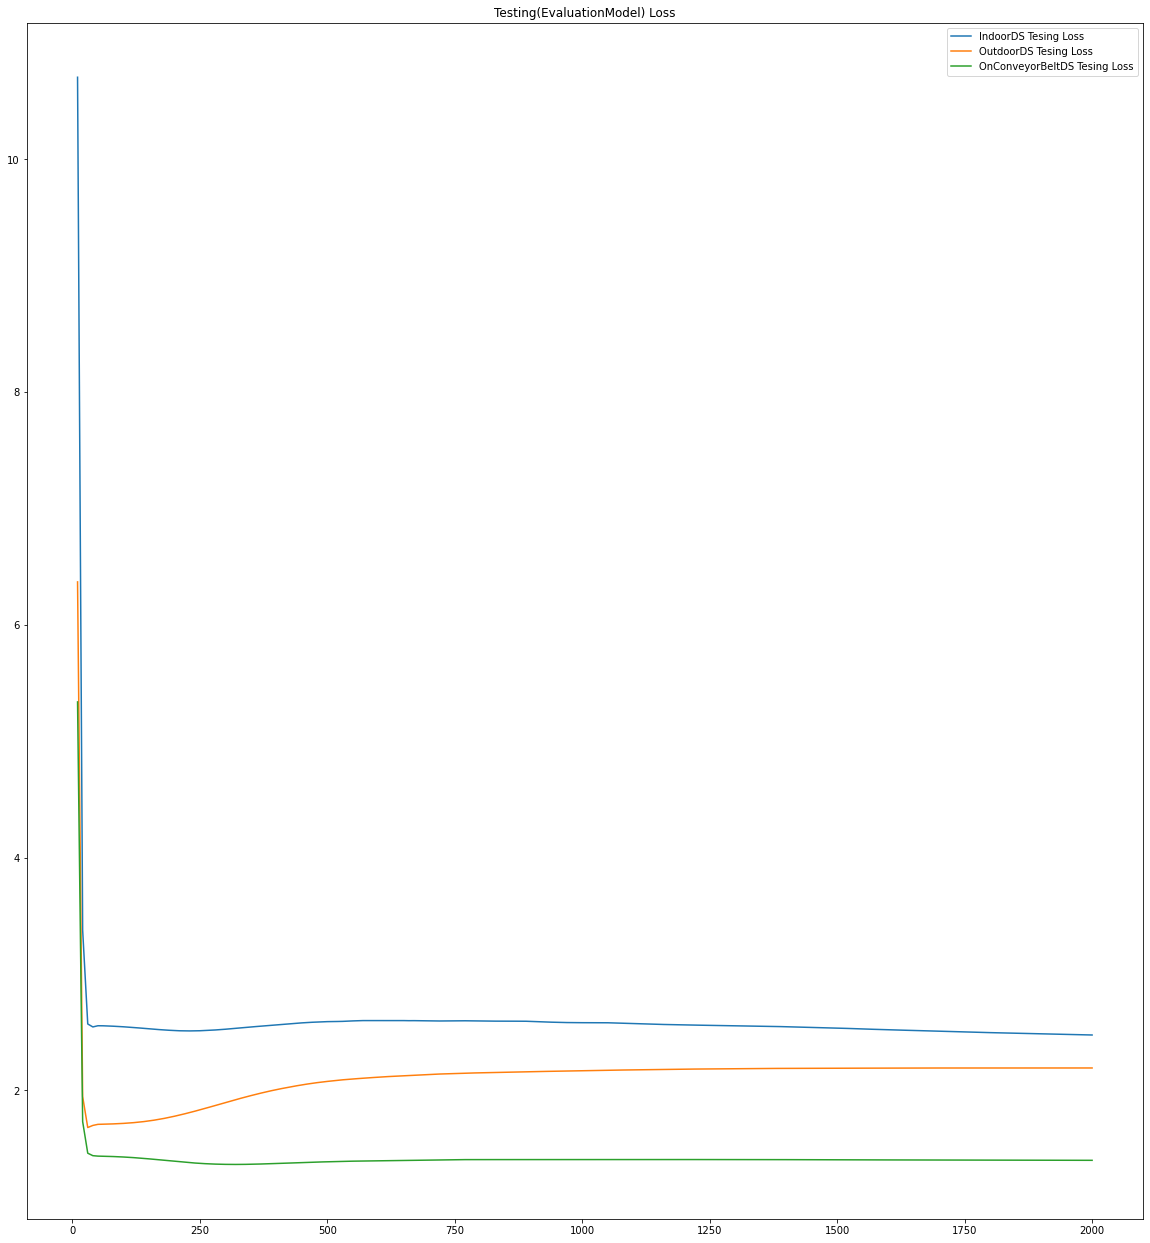

In [29]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [30]:
test_indoor_acc

[0.1588628739118576,
 0.47491639852523804,
 0.5551839470863342,
 0.5579710006713867,
 0.5590858459472656,
 0.5596432685852051,
 0.5590858459472656,
 0.5607580542564392,
 0.5613154768943787,
 0.5624303221702576,
 0.5646599531173706,
 0.5668896436691284,
 0.5680044889450073,
 0.5702341198921204,
 0.5713489651679993,
 0.5724637508392334,
 0.5741360187530518,
 0.5769230723381042,
 0.5785953402519226,
 0.5791527032852173,
 0.5802675485610962,
 0.582497239112854,
 0.5841694474220276,
 0.585841715335846,
 0.5875139236450195,
 0.5908583998680115,
 0.5914158225059509,
 0.5936455130577087,
 0.5947602987289429,
 0.5958751440048218,
 0.5958751440048218,
 0.5975473523139954,
 0.5981047749519348,
 0.5986621975898743,
 0.6014492511749268,
 0.6020066738128662,
 0.6053511500358582,
 0.6059085726737976,
 0.6053511500358582,
 0.6064659953117371,
 0.6081382632255554,
 0.6086956262588501,
 0.6092530488967896,
 0.6103678941726685,
 0.6109253168106079,
 0.6114827394485474,
 0.6120401620864868,
 0.61204016208

In [31]:
test_outdoor_acc

[0.3165605068206787,
 0.6092356443405151,
 0.6449044346809387,
 0.6471337676048279,
 0.6487261056900024,
 0.6487261056900024,
 0.6487261056900024,
 0.6484076380729675,
 0.6493630409240723,
 0.6496815085411072,
 0.6496815085411072,
 0.650318443775177,
 0.6493630409240723,
 0.6493630409240723,
 0.6496815085411072,
 0.653184711933136,
 0.6535031795501709,
 0.6538216471672058,
 0.6554139852523804,
 0.656050980091095,
 0.6550955176353455,
 0.6563694477081299,
 0.6582802534103394,
 0.6582802534103394,
 0.6576433181762695,
 0.6589171886444092,
 0.6592356562614441,
 0.6601910591125488,
 0.659554123878479,
 0.6601910591125488,
 0.6627388596534729,
 0.6633757948875427,
 0.6630573272705078,
 0.6630573272705078,
 0.6643311977386475,
 0.6665605306625366,
 0.6662420630455017,
 0.6675159335136414,
 0.6681528687477112,
 0.668789803981781,
 0.6694267392158508,
 0.6697452068328857,
 0.6700636744499207,
 0.6703821420669556,
 0.6700636744499207,
 0.6697452068328857,
 0.6700636744499207,
 0.670382142066955

In [32]:
test_belt_acc

[0.3680870234966278,
 0.6636446118354797,
 0.699002742767334,
 0.7058023810386658,
 0.7080689072608948,
 0.7080689072608948,
 0.7085222005844116,
 0.7094288468360901,
 0.7089754939079285,
 0.7098821401596069,
 0.7094288468360901,
 0.7094288468360901,
 0.7103354334831238,
 0.7112420797348022,
 0.7139618992805481,
 0.7139618992805481,
 0.7157751321792603,
 0.7171350717544556,
 0.718041718006134,
 0.718041718006134,
 0.7189483046531677,
 0.720308244228363,
 0.7221214771270752,
 0.7262012958526611,
 0.7275611758232117,
 0.7284678220748901,
 0.7298277616500854,
 0.7334542274475098,
 0.7343608140945435,
 0.7361740469932556,
 0.7370806932449341,
 0.7388939261436462,
 0.7407071590423584,
 0.7416138052940369,
 0.7420670986175537,
 0.7438803315162659,
 0.7452402710914612,
 0.745693564414978,
 0.7475067973136902,
 0.7484134435653687,
 0.7488667368888855,
 0.7488667368888855,
 0.7493200302124023,
 0.7493200302124023,
 0.7493200302124023,
 0.7493200302124023,
 0.7502266764640808,
 0.750226676464080

In [33]:
test_indoor_loss

[10.706878662109375,
 3.3760616779327393,
 2.569464683532715,
 2.5440633296966553,
 2.554269552230835,
 2.553842782974243,
 2.5522520542144775,
 2.5502495765686035,
 2.548024892807007,
 2.545280933380127,
 2.5422070026397705,
 2.5390264987945557,
 2.535473585128784,
 2.5316920280456543,
 2.527904987335205,
 2.524442195892334,
 2.521130084991455,
 2.5180506706237793,
 2.515352249145508,
 2.512864589691162,
 2.511075496673584,
 2.51012921333313,
 2.509819746017456,
 2.5101430416107178,
 2.5113232135772705,
 2.5132224559783936,
 2.515392780303955,
 2.5179502964019775,
 2.5209171772003174,
 2.524338722229004,
 2.5278921127319336,
 2.5317976474761963,
 2.5358967781066895,
 2.539914608001709,
 2.5435104370117188,
 2.5472872257232666,
 2.5509111881256104,
 2.554513931274414,
 2.5586459636688232,
 2.5618643760681152,
 2.5656750202178955,
 2.5695815086364746,
 2.573308229446411,
 2.5762791633605957,
 2.578958511352539,
 2.581778049468994,
 2.5841360092163086,
 2.586275339126587,
 2.587998390197

In [34]:
test_outdoor_loss

[6.369220733642578,
 1.946073055267334,
 1.6794549226760864,
 1.6974525451660156,
 1.7067471742630005,
 1.707912802696228,
 1.7091593742370605,
 1.7107067108154297,
 1.7126235961914062,
 1.71503484249115,
 1.7179007530212402,
 1.7213819026947021,
 1.7255369424819946,
 1.730413556098938,
 1.7361646890640259,
 1.7426185607910156,
 1.7498763799667358,
 1.7579563856124878,
 1.7667982578277588,
 1.7763361930847168,
 1.7864388227462769,
 1.7970961332321167,
 1.808218240737915,
 1.8196791410446167,
 1.8315274715423584,
 1.8436607122421265,
 1.8560264110565186,
 1.8685721158981323,
 1.8811899423599243,
 1.8937716484069824,
 1.9062268733978271,
 1.918473482131958,
 1.9305318593978882,
 1.9422861337661743,
 1.9536491632461548,
 1.9647953510284424,
 1.9755241870880127,
 1.9859079122543335,
 1.995743989944458,
 2.0049755573272705,
 2.013967990875244,
 2.0223491191864014,
 2.0306551456451416,
 2.0383682250976562,
 2.0459277629852295,
 2.0528039932250977,
 2.059309959411621,
 2.0652592182159424,
 2.

In [35]:
test_belt_loss

[5.337798118591309,
 1.7304613590240479,
 1.4588403701782227,
 1.437520980834961,
 1.4337248802185059,
 1.432773470878601,
 1.431553602218628,
 1.4300386905670166,
 1.428191900253296,
 1.426048755645752,
 1.4235219955444336,
 1.420686960220337,
 1.4174563884735107,
 1.4139388799667358,
 1.410140037536621,
 1.4061044454574585,
 1.4019827842712402,
 1.3977164030075073,
 1.3935154676437378,
 1.3893671035766602,
 1.3852752447128296,
 1.3813962936401367,
 1.377733826637268,
 1.3743644952774048,
 1.3714144229888916,
 1.3688327074050903,
 1.366668939590454,
 1.3650083541870117,
 1.3637535572052002,
 1.362845778465271,
 1.3622944355010986,
 1.3621681928634644,
 1.3623366355895996,
 1.362928032875061,
 1.3636635541915894,
 1.3647366762161255,
 1.3659820556640625,
 1.367296576499939,
 1.368747591972351,
 1.3700892925262451,
 1.3715087175369263,
 1.373075008392334,
 1.3747707605361938,
 1.3764349222183228,
 1.3780412673950195,
 1.3795263767242432,
 1.3810327053070068,
 1.3824548721313477,
 1.3838

## Load Last Epoch and test in each class

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch2000-val_acc0.98.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [2]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4923
FP=2217
acc=0.6894957983193277
all check = 7140


In [3]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 56.896551724137936%
2WayConnectorforFoley acc = 85.03401360544217%
2WayFoleyCatheter acc = 41.04477611940299%
3WayConnectorforFoley acc = 94.01709401709401%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.25%
AlcoholPad acc = 42.857142857142854%
BootCover acc = 61.44578313253012%
CottonBall acc = 100.0%
CottonSwap acc = 50.349650349650354%
Dilator acc = 77.77777777777779%
DisposableInfusionSet acc = 46.017699115044245%
ExtensionTube acc = 36.58536585365854%
FaceShield acc = 61.72839506172839%
FrontLoadSyringe acc = 37.16814159292036%
GauzePad acc = 44.88636363636363%
Glove acc = 75.0%
GuideWire acc = 25.0%
LiquidBottle acc = 63.358778625954194%
Mask acc = 93.76623376623377%
NGTube acc = 45.16129032258064%
NasalCannula acc = 43.36283185840708%
Needle acc = 93.57142857142857%
OxygenMask acc = 78.94736842105263%
PPESuit acc = 85.48387096774194%
PharmaceuticalProduct acc = 72.19626168224299%
Pill acc = 90.75630252100841%
PillBottle acc = 58.91472868

In [4]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 66,   7,   0, ...,   0,   0,   0],
       [  0, 125,   0, ...,   0,   0,   0],
       [  0,   0,  55, ...,   1,   0,   0],
       ...,
       [  0,   2,   0, ...,  36,  17,   0],
       [  0,   0,   0, ...,   0, 169,   0],
       [  0,   0,   0, ...,   0,   2,  59]], dtype=int64)

In [5]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[56.89655172,  6.03448276,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 85.03401361,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 41.04477612, ...,  0.74626866,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.66666667,  0.        , ..., 30.        ,
        14.16666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        79.342723  ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.75438596, 51.75438596]])

<AxesSubplot:>

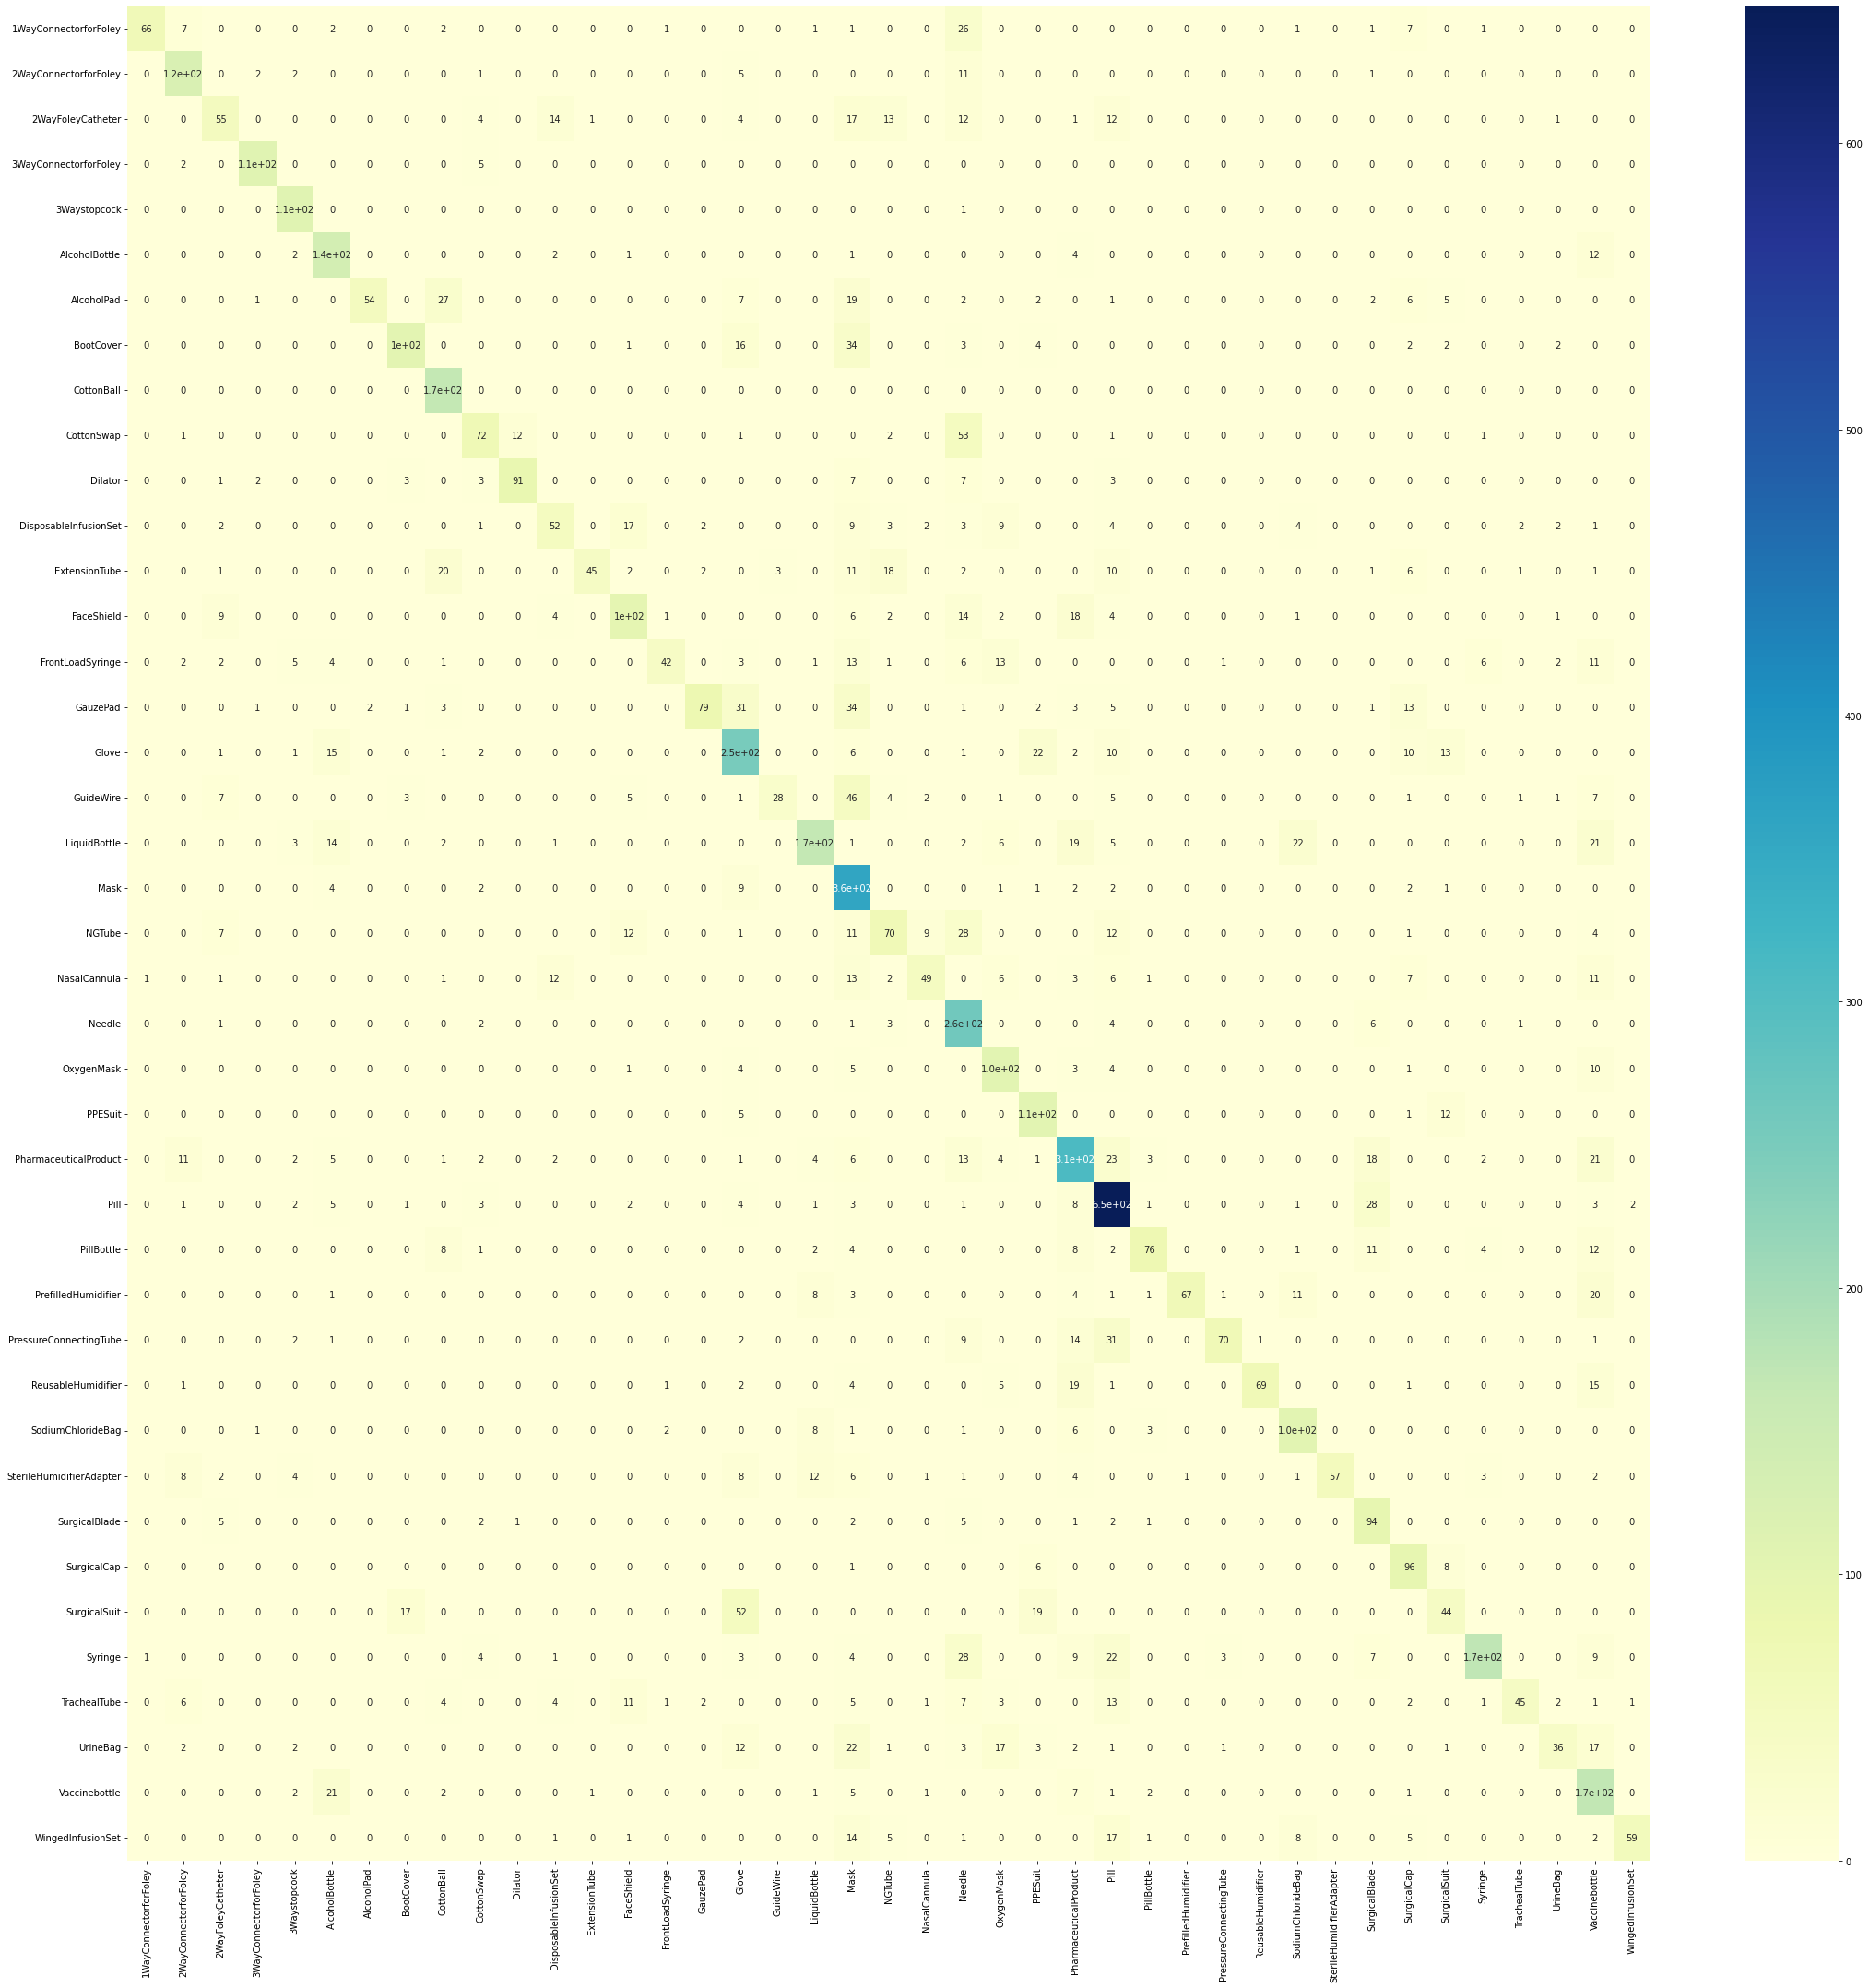

In [6]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

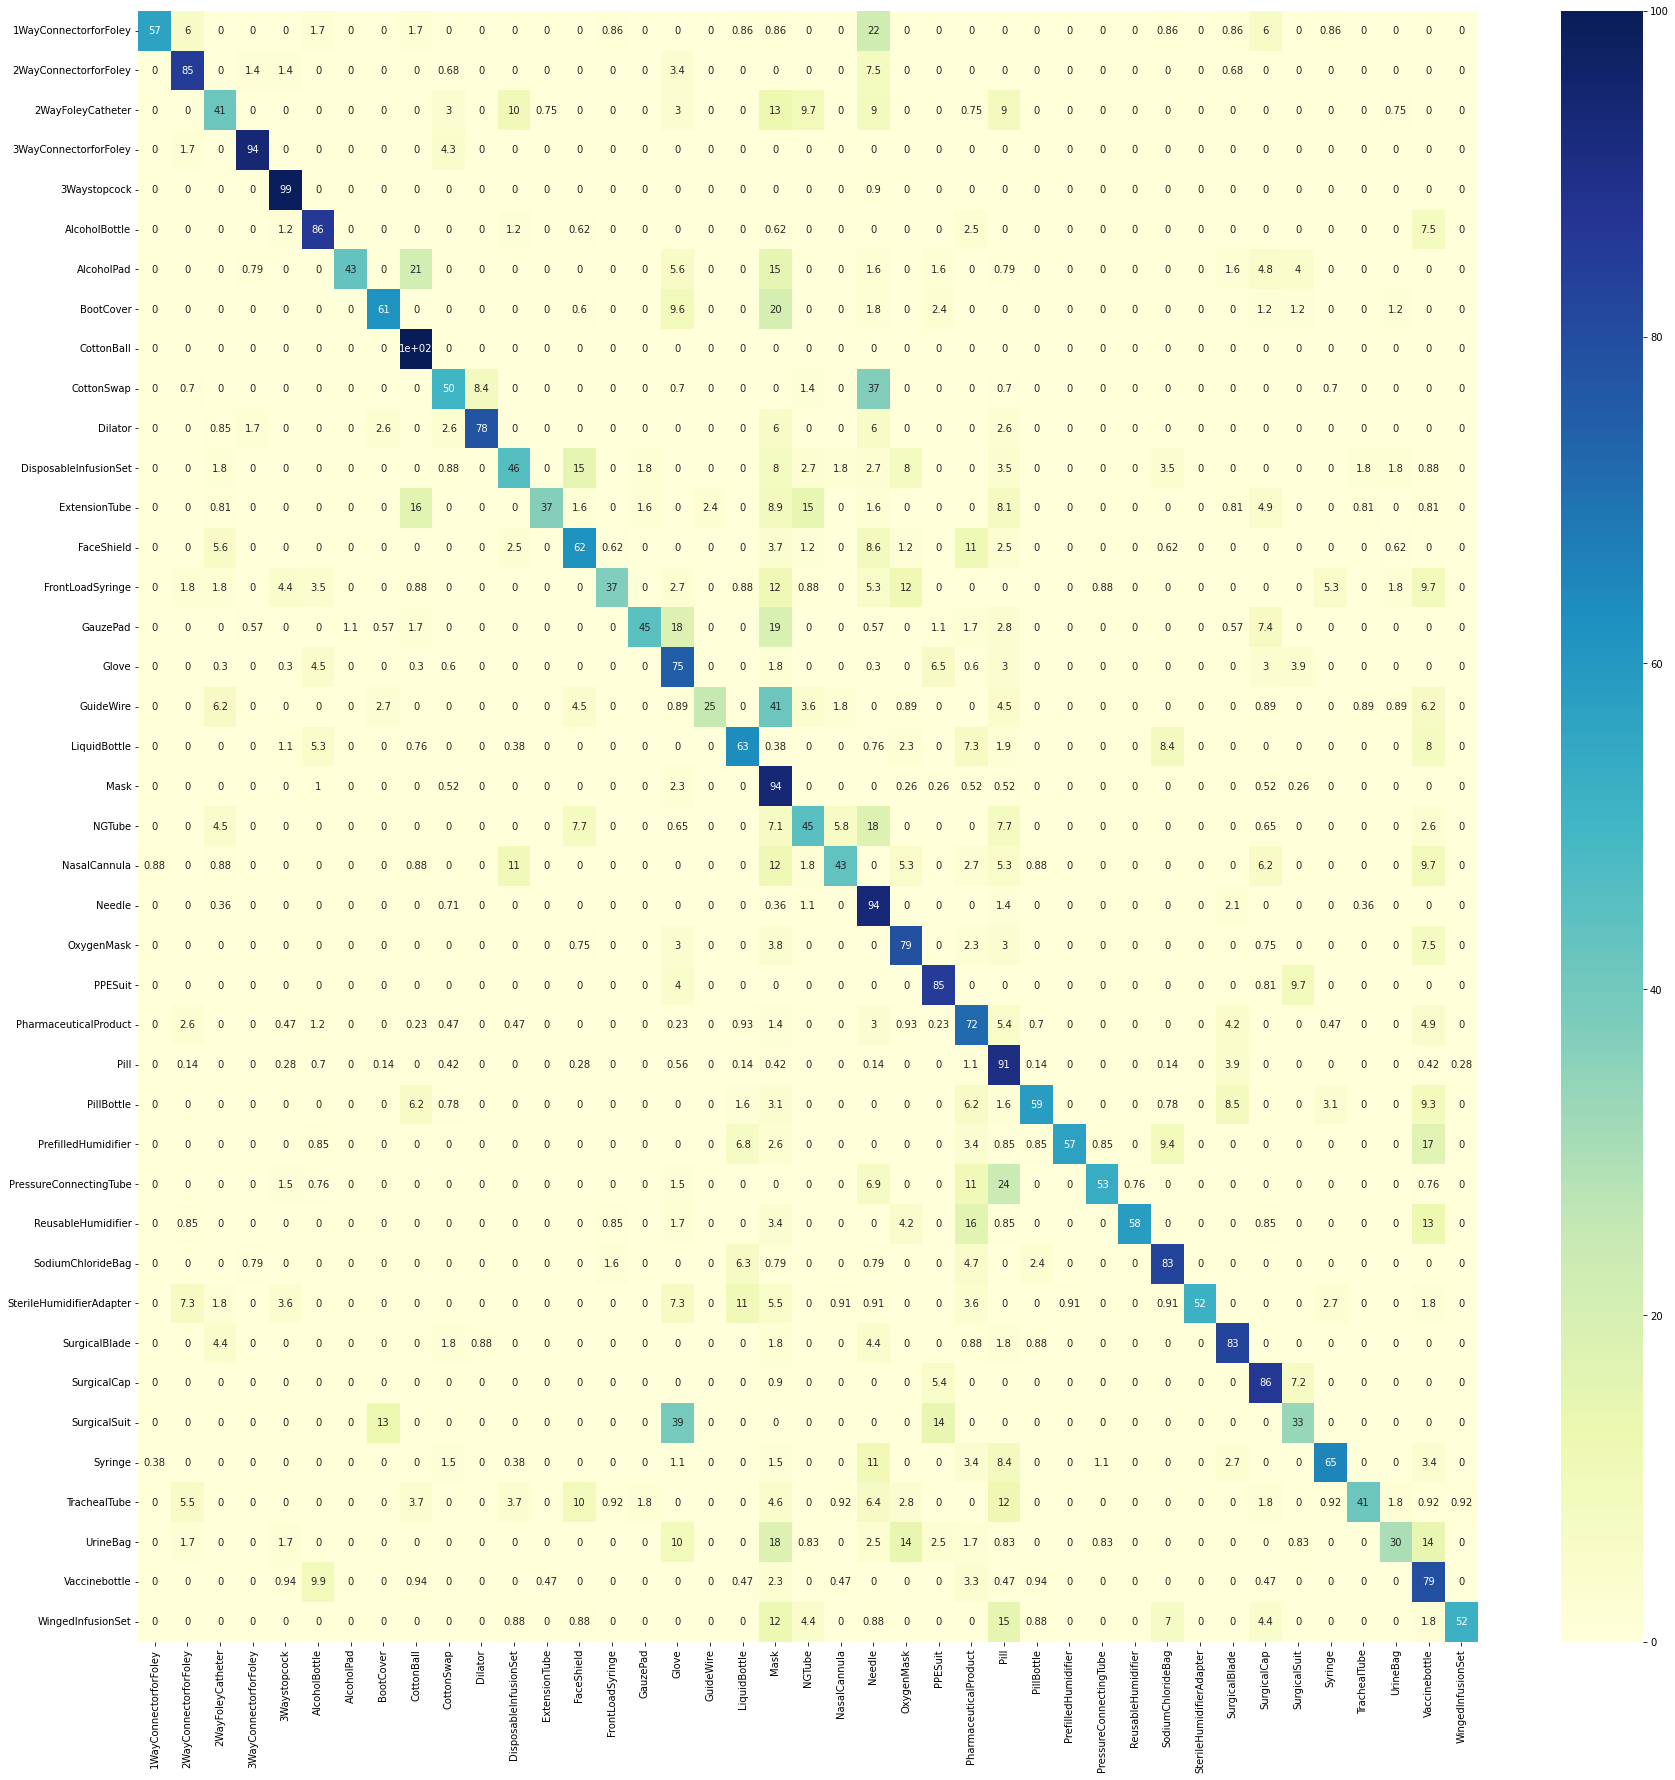

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")